In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

torch.__version__

'1.8.2'

In [2]:
model = torchvision.models.resnet50(pretrained=True)
model.eval()
# for name, module in model.named_modules():
#     print(f'{name} // {module}')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
class customimage(Dataset):
    def __init__(self):
        super(customimage, self).__init__()
        self.transform = transforms.Compose([
                                            transforms.Resize(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize(
                                                mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225])
                                            ])
    def __call__(self, input_img):
        img = Image.open(input_img)
        img = img.convert('RGB')
        return self.transform(img)

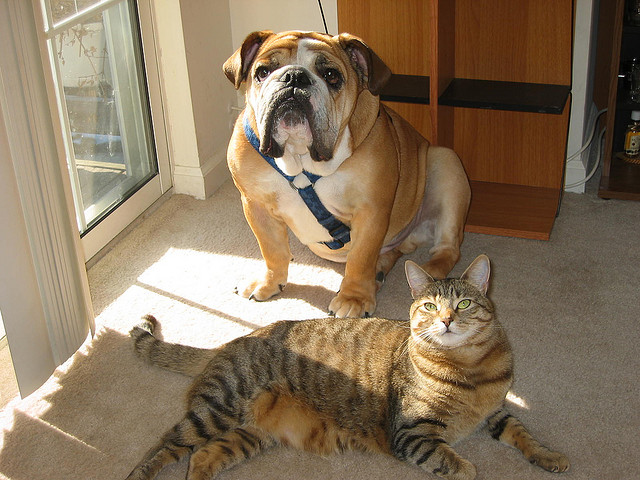

In [4]:
image_path = 'C:\\Users\\KangwooYi\\lecture\\243_bullmastiff_and_282_tigercat.jpg'
Image.open(image_path)

In [5]:
image_trans = customimage()
input_img = image_trans(image_path)
input_img = input_img.unsqueeze(dim=0)

In [6]:
result = torch.argmax(model(input_img))
print(result, model(input_img)[0][result])

tensor(243) tensor(7.7214, grad_fn=<SelectBackward>)


In [9]:
class GradCAMplusplus():
    def __init__(self, model):
        super(GradCAMplusplus, self).__init__()
        self.model = model
        self.model.eval()
    
    def forward_hook(self, name):
        def save_forward_hook(module, _, output):
            self.forward_out[name] = output.detach()
        return save_forward_hook

    def backward_hook(self, name):
        def save_backward_hook(module, _, grad_output):
            self.backward_out[name] = grad_output[0].detach()
        return save_backward_hook
    
    def get_gradient(self, input_tensorimage, target_layer, target_label=None):
        self.model.zero_grad()
        self.forward_out = {}
        self.backward_out = {}
        self.handlers = []
        self.gradients = []
        self.gradient_min_max = []
        self.target_layer = target_layer
        
        for name, module in self.model.named_modules():
            if name == self.target_layer:
#                 self.handlers.append(module.register_forward_hook(self.forward_hook(name)))
#                 self.handlers.append(module.register_backward_hook(self.backward_hook(name)))
                self.handlers.append(module.register_forward_hook(self.forward_hook(name)))
                self.handlers.append(module.register_full_backward_hook(self.backward_hook(name)))
                
        output = self.model(input_tensorimage)
        target_tensor = torch.zeros_like(output)
        if target_label is None:            
            target_tensor[0][int(torch.argmax(output))] = 1.
        else:
            target_tensor[0][target_label] = 1.  
        
        output.backward(target_tensor)
        
        features = self.forward_out[self.target_layer]
        grad = self.backward_out[self.target_layer]
        alpha_numer = grad.pow(2)
        alpha_denom = 2. * grad.pow(2) + grad.pow(3) * features.sum(dim=-1, keepdim=True).sum(dim=-2, keepdim=True)
        alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))
        alpha = alpha_numer / alpha_denom
        weight = (alpha * F.relu(grad)).sum(dim=-1, keepdim=True).sum(dim=-2, keepdim=True)
        
        CAM = features * weight
        CAM = CAM.sum(dim=1, keepdim=True)
        CAM = F.relu(CAM)
        
        self.model.zero_grad()
        for handle in self.handlers:
            handle.remove()
            
        return CAM
    
    def visualize(self, CAM, input_image):
        original_w, original_h = input_image.size[0], input_image.size[1]
        gradmap = F.interpolate(CAM, (original_h, original_w), mode='bilinear', align_corners=False)
        gradmap = torch.squeeze(gradmap)
        plt.figure(figsize=(original_h, original_w), dpi=1)

        plt.imshow(input_image)
        plt.imshow(gradmap, cmap='jet', alpha=0.5)
        
        plt.axis('off')
        plt.tight_layout()
        plt.show() 

In [10]:
GC = GradCAMplusplus(model)

In [11]:
GC_grad = GC.get_gradient(input_tensorimage=input_img, target_layer='layer4.2.conv3', target_label=243)

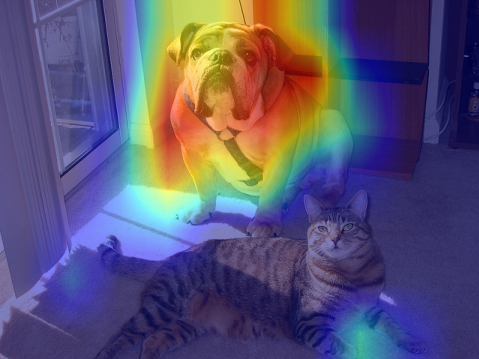

In [12]:
GC_vis = GC.visualize(GC_grad, input_image = Image.open(image_path))